In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
dataset = pd.read_csv('/kaggle/input/faces-age-detection-dataset/train.csv')

In [3]:
dataset.head(10)

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE
5,6283.jpg,MIDDLE
6,23495.jpg,YOUNG
7,7100.jpg,YOUNG
8,6028.jpg,YOUNG
9,22617.jpg,OLD


In [4]:
dataset['Class'].unique()

array(['MIDDLE', 'YOUNG', 'OLD'], dtype=object)

<AxesSubplot:>

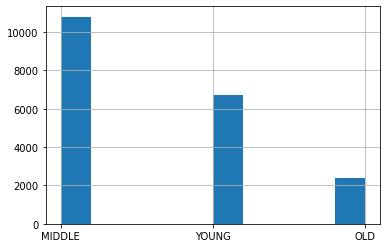

In [5]:
dataset['Class'].hist()

In [6]:
dataset['Class'].replace(['YOUNG', 'MIDDLE','OLD'], [0, 1, 2], inplace=True)

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import TensorBoard
from sklearn.metrics import classification_report,confusion_matrix
import itertools

In [8]:
# Methods for loading images.
def imageReader(path,ch = 3, resize=(64,64)):
    kp = tf.io.read_file(path)
    kp = tf.image.decode_jpeg(kp, channels=ch)
    kp = tf.image.convert_image_dtype(kp, dtype=tf.float32)
    kp = tf.image.resize(kp, resize)
    return kp

def load_data(image_path, label):
    image = imageReader(image_path, 3, (64,64))
    
    return (image, label)

In [9]:
import glob
# Initializing image paths variables.
image_paths = glob.glob('/kaggle/input/faces-age-detection-dataset/Train/*.jpg')
print(len(image_paths))

19906


In [10]:
# Initialize label values
label_list = []
for i in image_paths:
    _,tail = os.path.split(i)
    label = dataset.loc[dataset['ID'] == tail]['Class'].values[0]
    label_list.append(label)
# print(len(label_list))

In [11]:
import tensorflow as tf

# Create Train, Test, and Validation datasets
train_size = int(0.8*(len(image_paths)))
test_size = 20

train_dataset = tf.data.Dataset.from_tensor_slices((image_paths[:train_size], label_list[:train_size]))
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths[train_size:train_size + test_size], label_list[train_size :train_size + test_size]))
validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths[train_size + test_size:], label_list[train_size + test_size:]))

2022-12-14 06:40:48.707329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 06:40:48.708627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 06:40:48.821001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 06:40:48.821897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 06:40:48.822708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [12]:
# Creating Autotune objects
# For Autotune objects the prefetch buffer sizes are automitically tuned. 
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = (train_dataset
    .map(load_data, num_parallel_calls=AUTOTUNE)
    .batch(64)
    .prefetch(AUTOTUNE)
)


In [13]:
# Adding data agumentation to training images.
# Data agumentation adds variation to training data
train_dataset = train_dataset.map(
    lambda image, label: (tf.image.random_flip_left_right(image), label)
).cache(
).map(
    lambda image, label: (tf.image.per_image_standardization(image), label)
).map(
    lambda image, label: (tf.image.random_contrast(image, lower=0.4, upper=0.6), label)
).map(
    lambda image, label: (tf.image.random_brightness(image, max_delta = 0.4), label)
).map(
    lambda image, label: (tf.image.random_hue(image, max_delta = 0.4), label)
).map(
    lambda image, label: (tf.image.random_saturation(image, lower=0.4, upper=0.6), label)
).shuffle(
    1000
).repeat(2)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
validation_dataset = (validation_dataset
    .map(load_data, num_parallel_calls=AUTOTUNE)
    .batch(64)
    .prefetch(AUTOTUNE)
)

In [15]:
# Adding data agumentation to validation images.
validation_dataset = validation_dataset.map(
    lambda image, label: (tf.image.random_flip_left_right(image), label)
).cache(
).map(
    lambda image, label: (tf.image.per_image_standardization(image), label)
).map(
    lambda image, label: (tf.image.random_contrast(image, lower=0.4, upper=0.6), label)
).map(
    lambda image, label: (tf.image.random_brightness(image, max_delta = 0.4), label)
).map(
    lambda image, label: (tf.image.random_hue(image, max_delta = 0.4), label)
).map(
    lambda image, label: (tf.image.random_saturation(image, lower=0.4, upper=0.6), label)
).shuffle(
    1000
).repeat(2)

In [16]:
test_dataset = (test_dataset
    .map(load_data, num_parallel_calls=AUTOTUNE)
    .batch(64)
    .prefetch(AUTOTUNE)
)

In [17]:
# Standardizing the test data.
test_dataset = test_dataset.map(
    lambda image, label: (tf.image.per_image_standardization(image), label)
)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten


#create model
model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 25)        700       
_________________________________________________________________
activation (Activation)      (None, 62, 62, 25)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 25)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        7232      
_________________________________________________________________
activation_1 (Activation)    (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [20]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10


2022-12-14 06:40:53.910045: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-14 06:41:04.115680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 83 of 1000
2022-12-14 06:41:14.182481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 173 of 1000
2022-12-14 06:41:24.115980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 435 of 1000
2022-12-14 06:41:24.737020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-12-14 06:41:26.144706: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


498/498 [==============================] - 52s 23ms/step - loss: -505.9246 - accuracy: 0.5448 - val_loss: -5767.5679 - val_accuracy: 0.5384
Epoch 2/10
498/498 [==============================] - 10s 11ms/step - loss: -132492.7344 - accuracy: 0.5434 - val_loss: -648228.8125 - val_accuracy: 0.5384
Epoch 3/10
498/498 [==============================] - 11s 11ms/step - loss: -2286822.0000 - accuracy: 0.5437 - val_loss: -5980696.5000 - val_accuracy: 0.5384
Epoch 4/10
498/498 [==============================] - 10s 10ms/step - loss: -12562459.0000 - accuracy: 0.5393 - val_loss: -24006374.0000 - val_accuracy: 0.5384
Epoch 5/10
498/498 [==============================] - 10s 11ms/step - loss: -44776716.0000 - accuracy: 0.5431 - val_loss: -60115564.0000 - val_accuracy: 0.5384
Epoch 6/10
498/498 [==============================] - 10s 10ms/step - loss: -103008288.0000 - accuracy: 0.5399 - val_loss: -154293184.0000 - val_accuracy: 0.5384
Epoch 7/10
498/498 [==============================] - 9s 9ms/ste